In [1]:
import tensorflow as tf
import tensorflow.contrib.timeseries as ts
from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy

import multiprocessing
import pandas as pd
import numpy as np
import shutil
from datetime import datetime

import matplotlib.pyplot as plt
#%matplotlib inline

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


In [2]:
MODEL_NAME = 'ts-model-02'

TRAIN_DATA_FILES = ['data/train-data.csv']
TEST_DATA_FILE = 'data/test-data.csv'

RESUME_TRAINING = False
MULTI_THREADING = True

# Steps to use the ARRegressor + Experiment API
1. Define the **metadata**
2. Define a data (csv) **input function**
3. Define a **create Estimator** function
4. Run an **Experiment** with **learn_runner** to train, evaluate, and export the model
7. **Predict** using the estimator
8. **Serve** the saved model

## 1. Define Metadata

In [3]:
TIME_INDEX_FEATURE_NAME = 'time_index'
VALUE_FEATURE_NAMES = ['value']

## 2. Define a Data Input Function

In [4]:
def generate_input_fn(file_names, mode, skip_header_lines=1, batch_size = None, windows_size = None):
    
    columns = {
        ts.TrainEvalFeatures.TIMES: TIME_INDEX_FEATURE_NAME,
        ts.TrainEvalFeatures.VALUES: VALUE_FEATURE_NAMES
    }
    
    reader = tf.contrib.timeseries.CSVReader(filenames=file_names, 
                                    column_names=columns, 
                                    skip_header_lines=skip_header_lines)

    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        input_fn = tf.contrib.timeseries.RandomWindowInputFn(
            reader, 
            batch_size=batch_size, 
            window_size=windows_size,
            num_threads= num_threads
        )
        
    elif mode == tf.estimator.ModeKeys.EVAL:
        input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    
    return input_fn

## 3. Define a Create Estimator Function

In [5]:
def create_estimator(run_config, hparams):

    estimator = ts.ARRegressor(
        periodicities= hparams.periodicities, 
        input_window_size= hparams.input_window_size, 
        output_window_size= hparams.output_window_size,
        num_features=len(VALUE_FEATURE_NAMES),
        loss=hparams.loss,
        hidden_layer_sizes = hparams.hidden_units,
        
#         anomaly_prior_probability=hparams.anomaly_prob,
#         anomaly_distribution=hparams.anomaly_dist,
        
        optimizer = tf.train.AdagradOptimizer(learning_rate=hparams.learning_rate),
        config=run_config
    )
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 4. Run Experiment

### a. Set hyper-params values

In [6]:
CHECKPOINT_STEPS=1000

hparams  = tf.contrib.training.HParams(
    training_steps = 10000,
    periodicities = [200],
    input_window_size = 40,
    output_window_size=10,
    batch_size = 15,
    anomaly_prob = 0.5,
    anomaly_dist = "gaussian",
    loss = tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = None,
    learning_rate = 0.1
    
)
  
model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.contrib.learn.RunConfig(
    save_checkpoints_steps=CHECKPOINT_STEPS,
    tf_random_seed=19831060,
    model_dir=model_dir
)

                                             
print("Model directory: {}".format(run_config.model_dir))
print("Hyper-parameters: {}".format(hparams))
print("")

Model directory: trained_models/ts-model-02
Hyper-parameters: [('anomaly_dist', 'gaussian'), ('anomaly_prob', 0.5), ('batch_size', 15), ('hidden_units', None), ('input_window_size', 40), ('learning_rate', 0.1), ('loss', 'normal_likelihood_loss'), ('output_window_size', 10), ('periodicities', [200]), ('training_steps', 10000)]



### b. Define Experiment Function 

In [7]:
def generate_experiment_fn(**experiment_args):
    
    train_input_fn = generate_input_fn(
        TRAIN_DATA_FILES,
        skip_header_lines=1,
        mode = tf.estimator.ModeKeys.TRAIN,
        batch_size=hparams.batch_size,
        windows_size = hparams.input_window_size + hparams.output_window_size
    )

    eval_input_fn = generate_input_fn(
        TRAIN_DATA_FILES,
        skip_header_lines=1,
        mode = tf.estimator.ModeKeys.EVAL,
        windows_size = hparams.input_window_size + hparams.output_window_size
    )

    def _experiment_fn(run_config, hparams):

        estimator = create_estimator(run_config, hparams)

        return tf.contrib.learn.Experiment(
            estimator,
            train_steps=hparams.training_steps,
            eval_steps=1,
            train_input_fn=train_input_fn,
            eval_input_fn=eval_input_fn,
            **experiment_args
        )

    return _experiment_fn

## 5. Run the Experiment

In [8]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 


tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 


learn_runner.run(
    experiment_fn=generate_experiment_fn(),
    run_config=run_config,
    schedule="train", #"train_and_evaluate"
    hparams=hparams
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Experiment started at 17:50:19
.......................................
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ef4e3c8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19831060, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 1000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/ts-model-02'}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>

Instructions for updating:
Please switch to tf.train.get_global_step
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints 

INFO:tensorflow:global_step/sec: 372.23
INFO:tensorflow:loss = 0.166662, step = 6201 (0.267 sec)
INFO:tensorflow:global_step/sec: 391.742
INFO:tensorflow:loss = 0.216219, step = 6301 (0.258 sec)
INFO:tensorflow:global_step/sec: 392.963
INFO:tensorflow:loss = 0.271654, step = 6401 (0.254 sec)
INFO:tensorflow:global_step/sec: 407.161
INFO:tensorflow:loss = 0.234456, step = 6501 (0.245 sec)
INFO:tensorflow:global_step/sec: 419.361
INFO:tensorflow:loss = 0.149325, step = 6601 (0.236 sec)
INFO:tensorflow:global_step/sec: 404.714
INFO:tensorflow:loss = 0.187818, step = 6701 (0.250 sec)
INFO:tensorflow:global_step/sec: 402.381
INFO:tensorflow:loss = 0.181293, step = 6801 (0.247 sec)
INFO:tensorflow:global_step/sec: 397.682
INFO:tensorflow:loss = -0.00449062, step = 6901 (0.253 sec)
INFO:tensorflow:Saving checkpoints for 7001 into trained_models/ts-model-02/model.ckpt.
INFO:tensorflow:global_step/sec: 132.732
INFO:tensorflow:loss = 0.130109, step = 7001 (0.753 sec)
INFO:tensorflow:global_step/

## 6. Evalute the Estimator

In [9]:
hparams.loss = tf.contrib.timeseries.ARModel.SQUARED_LOSS # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
 
estimator = create_estimator(run_config, hparams)

eval_input_fn = generate_input_fn(
    file_names=TRAIN_DATA_FILES,
    mode = tf.estimator.ModeKeys.EVAL,
)

tf.logging.set_verbosity(tf.logging.WARN)
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)
print("")
print(evaluation.keys())
print("")
print("Evaluation Loss ({}) : {}".format(hparams.loss, evaluation['loss']))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ef4e3c8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19831060, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 1000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/ts-model-02'}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>


dict_keys(['covariance', 'loss', 'mean', 'observed', 'start_tuple', 'times', 'global_step'])

Evaluation Loss (squared_loss) : 0.19278353452682495


In [10]:
def compute_rmse(a, b):
    rmse =  np.sqrt(np.sum(np.square(a - b)) / len(a))
    return rmse

def compute_mae(a, b):
    rmse =  np.sqrt(np.sum(np.abs(a - b)) / len(a))
    return rmse

In [11]:
x_current = evaluation['times'][0]
y_current_actual = evaluation['observed'][0].reshape(-1)
y_current_estimated = evaluation['mean'][0].reshape(-1)

rmse = compute_rmse(y_current_actual, y_current_estimated)
mae = compute_mae(y_current_actual, y_current_estimated)
print("Evaluation RMSE {}".format(rmse))
print("Evaluation MAE {}".format(mae))

Evaluation RMSE 0.4390712382149373
Evaluation MAE 0.5812069138274865


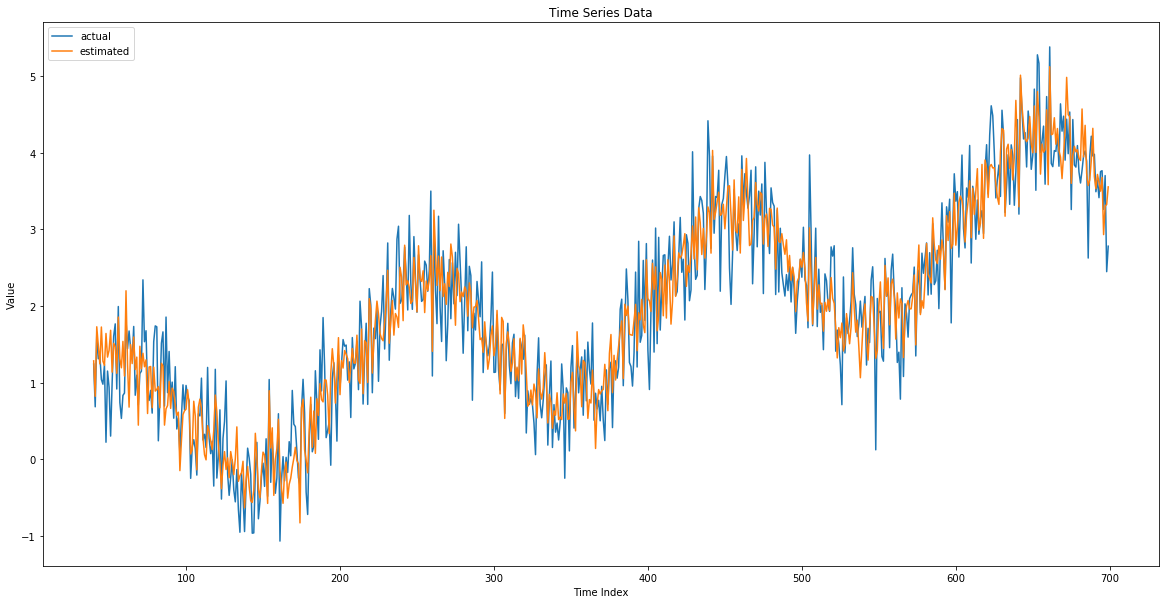

In [12]:
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_current, y_current_actual, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

## 7. Predict using the Estimator

In [22]:
FORECAST_STEPS = [10,50,100,150,200,250,300]

tf.logging.set_verbosity(tf.logging.ERROR)

eval_input_fn = generate_input_fn(
    file_names =TRAIN_DATA_FILES,
    mode = tf.estimator.ModeKeys.EVAL
)


evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)

df_test = pd.read_csv(TEST_DATA_FILE, names=['time_index','value'], header=0)
print("Test Dataset Size: {}".format(len(df_test)))
print("")

for steps in FORECAST_STEPS:

    forecasts = estimator.predict(input_fn=ts.predict_continuation_input_fn(evaluation, steps=steps))
    forecasts = tuple(forecasts)[0]
    
    x_next = forecasts['times']
    
    y_next_forecast = forecasts['mean']
    y_next_actual = df_test.value[:steps].values
    
    rmse =  compute_rmse(y_next_actual, y_next_forecast)
    mae =  compute_mae(y_next_actual, y_next_forecast)

    print("Forecast Steps {}: RMSE {} - MAE {}".format(steps,rmse,mae))

print("")
print(forecasts.keys())

Test Dataset Size: 300

Forecast Steps 10: RMSE 1.9936394778372102 - MAE 2.2743827214709342
Forecast Steps 50: RMSE 4.591944294681093 - MAE 5.160628494779687
Forecast Steps 100: RMSE 7.566335809273664 - MAE 7.772297081132177
Forecast Steps 150: RMSE 16.471776556868893 - MAE 12.724165150969178
Forecast Steps 200: RMSE 20.98392475881654 - MAE 15.546772532587175
Forecast Steps 250: RMSE 21.433018212770218 - MAE 16.607481520114312
Forecast Steps 300: RMSE 22.322000108274846 - MAE 17.71527927263785

dict_keys(['mean', 'covariance', 'times'])


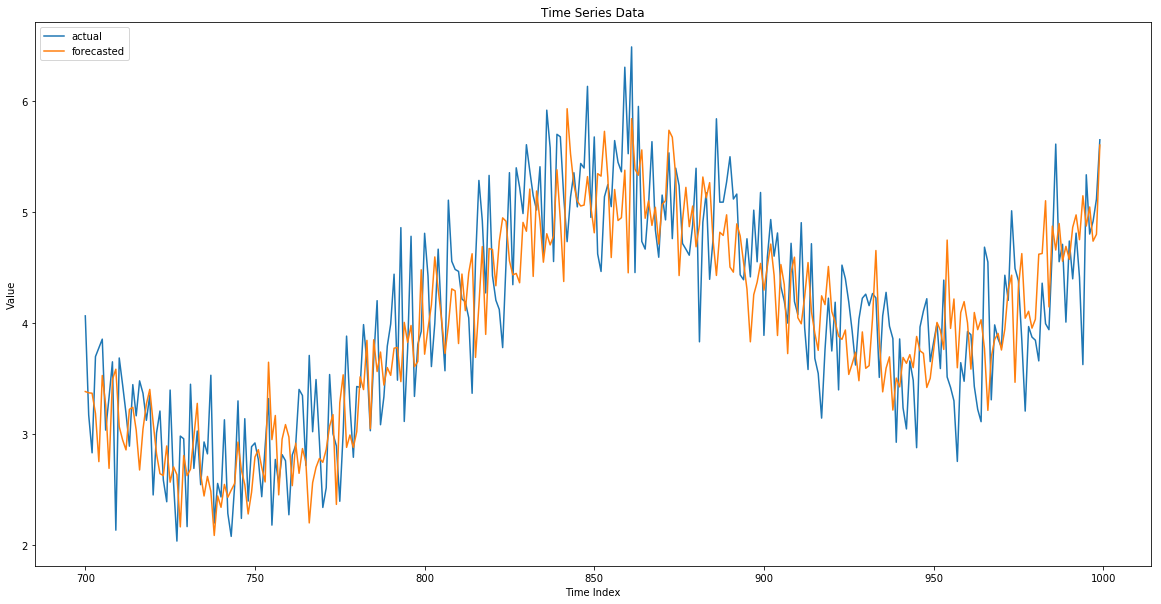

In [14]:
plt.close('all')
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_next, y_next_actual, label='actual')
plt.plot(x_next, y_next_forecast, label='forecasted')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

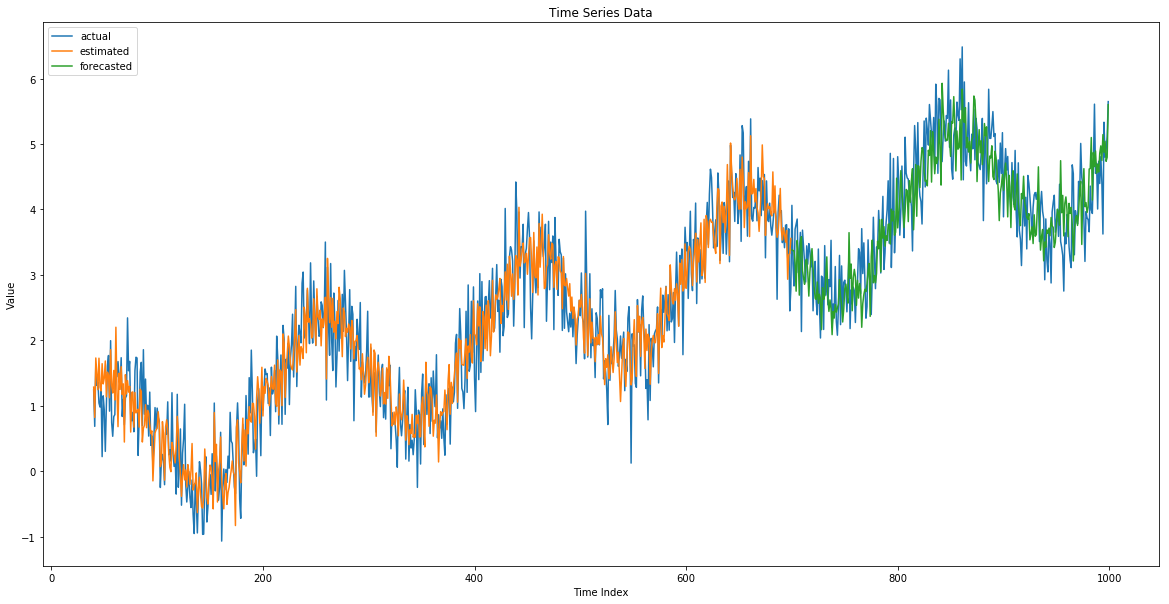

In [15]:
x_all = np.concatenate( (x_current, x_next) , axis=0)
y_actual_all = np.concatenate((y_current_actual, y_next_actual), axis=0)

plt.close('all')
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_all, y_actual_all, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.plot(x_next, y_next_forecast, label='forecasted')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

## 8. Save & Serve Model

In [19]:
export_dir = model_dir + "/expo"

estimator.export_savedmodel(
    export_dir_base=export_dir,
    serving_input_receiver_fn=estimator.build_raw_serving_input_receiver_fn(),
    as_text=True
)

b'trained_models/ts-model-02/expo/1510691426'

In [66]:
import os

saved_model_dir = export_dir +"/"+os.listdir(path=export_dir)[-1] 

input_values = df_test.value[:40].values

print(saved_model_dir)

predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = saved_model_dir
)

times = np.arange(1,250)

output = predictor_fn(
    {
        "model_state_00":[input_values],
        "model_state_01":input_values.reshape(1,40,1),
        "times": [times]
    }

)
predictions = list(map(lambda ls: ls[0],output["mean"][0]))

trained_models/ts-model-02/expo/1510691426


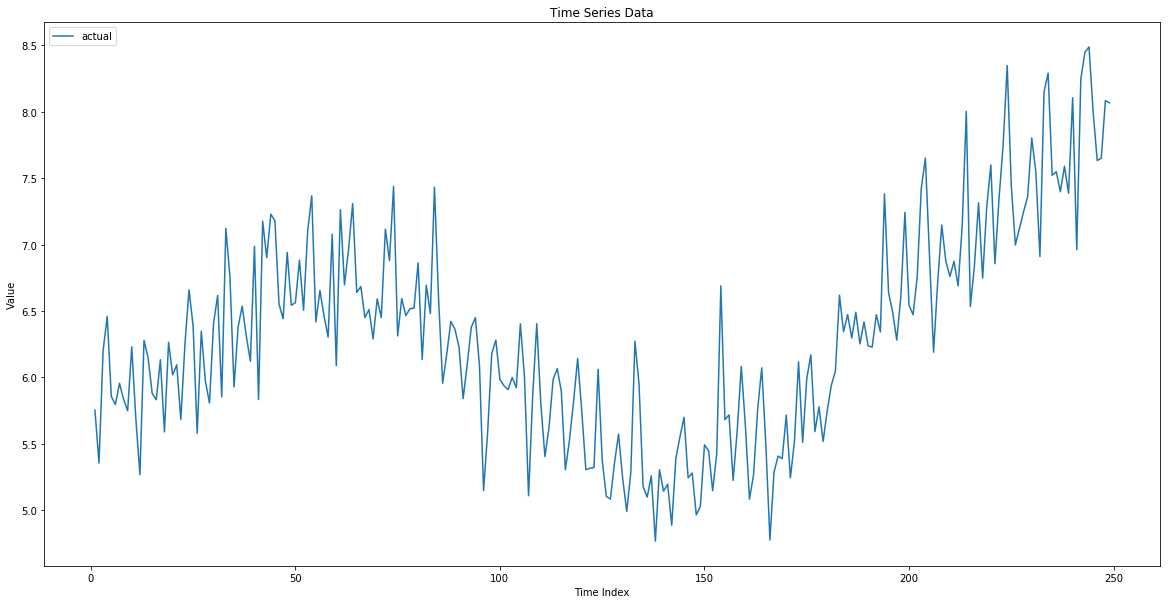

In [67]:
plt.close('all')
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(times, predictions, label='actual')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()